# Imports

In [27]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime
import os
import random as rn
import time
from os.path import join

import eif
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from scipy.stats import multivariate_normal

sb.set_style(style="whitegrid")
sb.set_color_codes()
import sys

import numpy.ma as ma
import scipy.ndimage
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
from numpy.random import seed, uniform
from scipy.interpolate import griddata
from scipy.special import softmax
from sklearn.datasets import (
    load_digits,
    load_iris,
    make_blobs,
    make_circles,
    make_classification,
    make_moons,
)
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imodels.util.data_util import get_clean_dataset
import pmlb

sys.path.append("..")
import sif

sys.path.append('../../imodels-experiments')
import config

# import eif_old as eif

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
dt = datetime.datetime.fromtimestamp(time.time())
logdir = os.path.join("./outputs/", dt.strftime("%Y-%m-%d"))

print(f"Logging to {logdir}")
if not os.path.exists(logdir):
    os.makedirs(logdir)

Logging to ./outputs/2022-01-14


# Utility Functions

These utility functions are used in creating the radial plots below. We use these two functions to find the depth (not anomaly score) a given data point reaches in an Isolation Forest tree. 

In [3]:
def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == "exNode":
        return d
    else:
        if (x - p).dot(n) < 0:
            return getDepth(x, root.left, d + 1)
        else:
            return getDepth(x, root.right, d + 1)


def getVals(forest, x, sorted=True):
    theta = np.linspace(0, 2 * np.pi, forest.ntrees)
    r = []
    for i in range(forest.ntrees):
        temp = forest.compute_paths_single_tree(np.array([x]), i)
        r.append(temp[0])
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

# Construct Datasets

In [13]:
def construct_datasets(n_samples, noise=0.1):
    # linearly separable
    X, y = make_classification(
        n_samples=n_samples,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        random_state=1,
        n_clusters_per_class=1,
    )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    # independent high dimensional guassian
    guassian_one = rng.normal(5, 1, (n_samples, 10))
    guassian_two = rng.normal(-5, 1, (n_samples, 10))
    X = np.concatenate((guassian_one, guassian_two))
    y = np.concatenate(([0] * n_samples, [1] * n_samples))
    ind_high_dim_guassian = (X, y)

    # non overlapping blobs
    centers = [(-5, -5), (5, 5)]
    X, y = make_blobs(
        n_samples=n_samples, centers=centers, shuffle=False, random_state=42
    )
    y[: n_samples // 2] = 0
    y[n_samples // 2 :] = 1
    separated_blobs = (X, y)

    # overlapping blobs
    centers = [(1, 1), (1, 3)]
    X, y = make_blobs(
        n_samples=n_samples, centers=centers, shuffle=False, random_state=42
    )
    y[: n_samples // 2] = 0
    y[n_samples // 2 :] = 1
    overlapping_blobs = (X, y)

    # iris data (2 features)
    iris = load_iris()
    X, y = iris.data[:, :2], iris.target  # we only take the first two features.
    iris_first_two_feats = (X, y)

    # mnist (2 pcs)
    X, y = load_digits(return_X_y=True)
    pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=42))
    X = pca.fit_transform(X)
    pca_mnist = (X, y)

    ds = [
        make_moons(n_samples=n_samples, noise=noise, random_state=42),
        make_circles(n_samples=n_samples, noise=noise, factor=0.8, random_state=42),
        linearly_separable,
        separated_blobs,
        overlapping_blobs,
        iris_first_two_feats,
        pca_mnist,
    ]

    names = [
        "moons",
        "circles",
        "linearly_separable",
        "separated_blobs",
        "overlapping_blobs",
        "iris_first_two_feats",
        "pca_mnist",
    ]
    
    return ds, names

In [14]:
def get_imodels_datasets():
    DATASETS_CLASSIFICATION, DATASETS_REGRESSION, \
    ESTIMATORS_CLASSIFICATION, ESTIMATORS_REGRESSION = config.get_configs('sif')
    datasets = DATASETS_CLASSIFICATION
    ests = ESTIMATORS_CLASSIFICATION
    
    ds = []
    names = []
    for d in datasets:
        X, y, feat_names = get_clean_dataset(d[1], data_source=d[2])
        ds.append((X, y))
        names.append(d[0])
    return ds, names

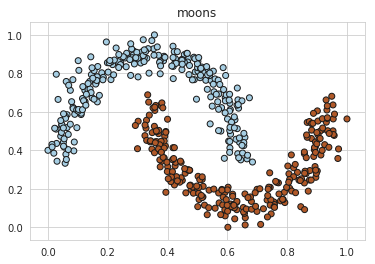

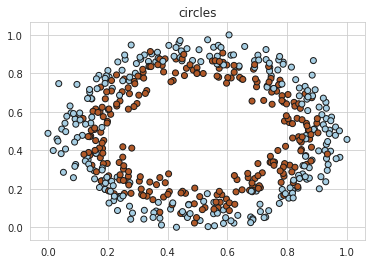

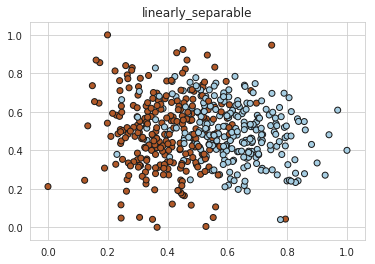

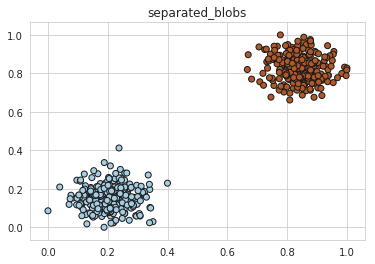

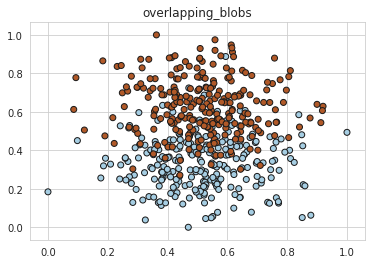

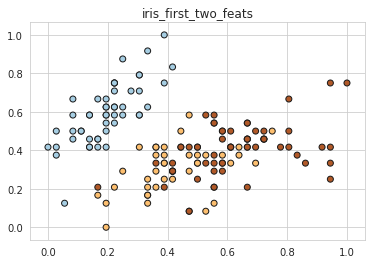

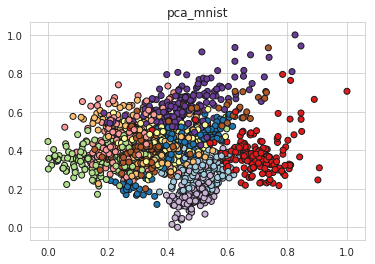

In [12]:
datasets, names = construct_datasets(512)
for name, ds in zip(names, datasets):
    X, y = ds
    # Data should be scaled to the range 0-1 for cross-entropy reconstruction loss.
    X = MinMaxScaler().fit_transform(X)

    plt.title(name)
    plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")
    plt.show();

# Score Maps

In [16]:
def plot_sif(ds, name, n_trees=500, el=0, scatter=True):
    X, y = ds
    X = MinMaxScaler().fit_transform(X)

    x1, x2 = X[:, 0], X[:, 1]
    xlim_low, xlim_high = min(x1), max(x1)
    ylim_low, ylim_high = min(x2), max(x2)
    xx, yy = np.meshgrid(
        np.linspace(xlim_low, xlim_high, 30), np.linspace(ylim_low, ylim_high, 30)
    )

    sample_size = min(256, int(0.5 * len(X)))

    F0 = eif.iForest(X, ntrees=n_trees, sample_size=sample_size, ExtensionLevel=el)
    S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
    S0 = S0.reshape(xx.shape)

    F1 = sif.iForest(X, y, ntrees=n_trees, sample_size=sample_size, ExtensionLevel=el)
    F1.fit(X, y)
    S1 = F1.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
    S1 = S1.reshape(xx.shape)

    S0 = np.log2(S0) * -F1.c  # undo anomaly score calc
    S1 = np.log2(S1) * -F1.c  # undo anomaly score calc
    #     S1 = 1 - S1 # anomaly detector reversed

    f = plt.figure(figsize=(15, 10))

    ########################
    ### DEPTH HEAT MAP
    #########################
    ax1 = f.add_subplot(232)
    eif_levels = np.linspace(np.min(S0), np.max(S0), 10)
    CS = ax1.contourf(xx, yy, S0, eif_levels, cmap=plt.cm.viridis)
    plt.scatter(x1, x2, s=15, c=y, edgecolor="k")
    plt.title("standard IF\ntree depth map")
    plt.colorbar(CS, ax=ax1)
    ax1.set_ylim(ylim_low, ylim_high)
    ax1.set_xlim(xlim_low, xlim_high)

    ax2 = f.add_subplot(235)
    sif_levels = np.linspace(np.min(S1), np.max(S1), 10)
    CS = ax2.contourf(xx, yy, S1, sif_levels, cmap=plt.cm.viridis)
    plt.scatter(x1, x2, s=15, c=y, edgecolor="k")
    plt.title(f"supervised IF\ntree depth map")
    plt.colorbar(CS, ax=ax2)
    ax2.set_ylim(ylim_low, ylim_high)
    ax2.set_xlim(xlim_low, xlim_high)

    ########################
    ### DEPTH HEAT MAP (no scatter)
    #########################
    ax3 = f.add_subplot(233)
    CS = ax3.contourf(xx, yy, S0, eif_levels, cmap=plt.cm.viridis)
    plt.title("standard IF\ntree depth map")
    plt.colorbar(CS, ax=ax3)
    ax3.set_ylim(ylim_low, ylim_high)
    ax3.set_xlim(xlim_low, xlim_high)

    ax4 = f.add_subplot(236)
    CS = ax4.contourf(xx, yy, S1, sif_levels, cmap=plt.cm.viridis)
    plt.title(f"supervised IF\ntree depth map")
    plt.colorbar(CS, ax=ax4)
    ax4.set_ylim(ylim_low, ylim_high)
    ax4.set_xlim(xlim_low, xlim_high)

    ########################
    ### DEPTH HISTOGRAM
    #########################

    S0 = F0.compute_paths(X_in=X)
    S0 = np.log2(S0) * -F1.c  # undo anomaly score calc

    S1 = F1.compute_paths(X_in=X)
    S1 = np.log2(S1) * -F1.c  # undo anomaly score calc

    ax5 = f.add_subplot(231)
    ax5.hist(S0)
    ax5.set_title(
        "standard IF, avg depth of data in forest\nMean={0:.2f}, Var={1:.2f}.".format(
            np.mean(S0), np.var(S0)
        )
    )

    ax6 = f.add_subplot(234, sharex=ax5)
    ax6.hist(S1)
    ax6.set_title(
        "supervised IF, avg avg depth of data in forest\nMean={0:.2f}, Var={1:.2f}.".format(
            np.mean(S1), np.var(S1)
        )
    )
    f.suptitle(name, fontsize=16)
    plt.savefig((join(logdir, f"{name}-score-map")))
    plt.show()
    return F1.Trees

In [19]:
datasets, names = construct_datasets(512)
# datasets, names = get_imodels_datasets()
to_test = ["separated_blobs", "overlapping_blobs"]
to_test = names

NameError: name 'logdir' is not defined

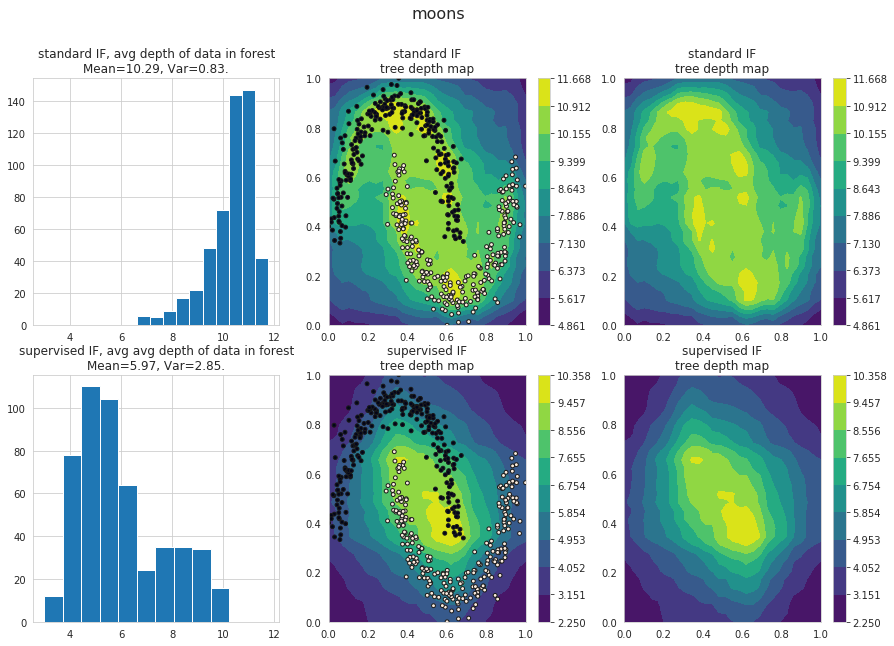

In [20]:
for name, ds in zip(names, datasets):
    if name in to_test:
        trees = plot_sif(ds, name, n_trees=100, el=0)

# SIF Score vs Acc

In [29]:
def plot_sif_score_vs_acc(ds, name, n_trees, el, classifier):
    # classifiers = ['MLP', 'RandomForest']
    f = plt.figure(figsize=(10, 10))

    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, random_state=1, test_size=0.5
    )
    if classifier == 'MLP':
        clf = MLPClassifier(random_state=1, max_iter=1000)
    if classifier == 'RandomForest':
        clf = RandomForestClassifier(random_state=1, n_estimators=100)
    clf.fit(X_train, y_train)

    sample_size = min(256, int(0.5 * len(X)))
    F1 = sif.iForest(
        X_train, y_train, ntrees=n_trees, sample_size=sample_size, ExtensionLevel=el
    )
    F1.fit(X_train, y_train)
    S1 = F1.compute_paths(X_in=X_test)

    ########################
    ### PRED PROB VS ACC
    ########################
    ax1 = f.add_subplot(221)
    acc = []
    max_pred_prob = np.max(clf.predict_proba(X_test), axis=1)
    quantiles = np.arange(0, 1, 0.05)
    quantiles = np.append(quantiles, 1)
    x = []
    # find binned accuracy for pred prob
    thresholds = np.quantile(max_pred_prob, quantiles)
    from collections import Counter
    
    for i in range(1, len(thresholds)):
        curr_thresh = thresholds[i - 1]
        next_thresh = thresholds[i]
        # handle edge case where quantiles include a repeated number
        if next_thresh == curr_thresh:
            idx_between_thresh = np.where(max_pred_prob == curr_thresh)[0]
        else:
            idx_between_thresh = np.where(
                np.logical_and(max_pred_prob > curr_thresh, max_pred_prob <= next_thresh)
            )[0]
        if len(idx_between_thresh): # there are points between these thresholds
            acc.append(clf.score(X_test[idx_between_thresh], y_test[idx_between_thresh]))
            x.append(quantiles[i])
    
    ax1.scatter(x, acc)
    ax1.plot([0, 1], [0, 1], "--", color="tab:orange")
    ax1.set_title(f"{classifier} max class pred prob vs acc")
    ax1.set_xlabel("max pred prob (quantiles)")
    ax1.set_ylabel("acc")

    ax2 = f.add_subplot(222)
    ax2.hist(max_pred_prob)
    ax2.set_title(
        f"pred prob distribution\nmean={np.mean(max_pred_prob):.3f}, var={np.var(max_pred_prob):.3f}"
    )

    ########################
    ### SIF SCORES VS ACC
    ########################
    ax3 = f.add_subplot(223)
    acc = []
    x = quantiles[:-1]
    # find binned accuracy for sif scores
    thresholds = np.quantile(S1, quantiles)
    for i in range(1, len(thresholds)):
        curr_thresh = thresholds[i - 1]
        next_thresh = thresholds[i]
        idx_between_thresh = np.where(
            np.logical_and(S1 > curr_thresh, S1 <= next_thresh)
        )[0]
        acc.append(clf.score(X_test[idx_between_thresh], y_test[idx_between_thresh]))
    ax3.scatter(x, acc)
    ax3.plot([0, 1], [0, 1], "--", color="tab:orange")
    ax3.set_title("SIF loner score vs acc")
    ax3.set_xlabel("loner score (quantiles)")
    ax3.set_ylabel("acc")

    ax4 = f.add_subplot(224)
    ax4.hist(S1)
    ax4.set_title(
        f"loner score distribution\nmean={np.mean(S1):.3f}, var={np.var(S1):.3f}"
    )

    f.suptitle(f"{name}\n{classifier} test acc: {clf.score(X_test, y_test):.3f}", fontsize=16)
    plt.savefig(join(logdir, f"{name}-{classifier}-loner-score-acc"))
    plt.show()

In [30]:
classifiers = ['MLP', 'RandomForest']
# datasets, names = construct_datasets(2 ** 12, noise=0.3)
datasets, names = get_imodels_datasets()
# to_test = ['iris_first_two_feats']
to_test = names + classifiers + [0]

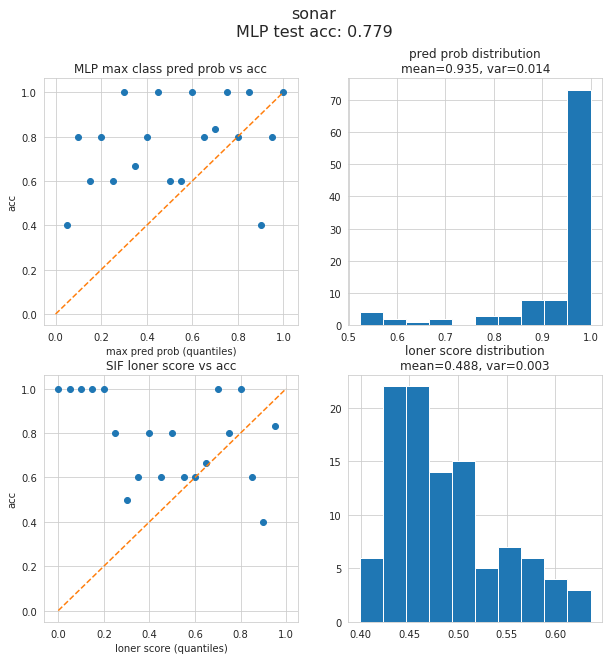

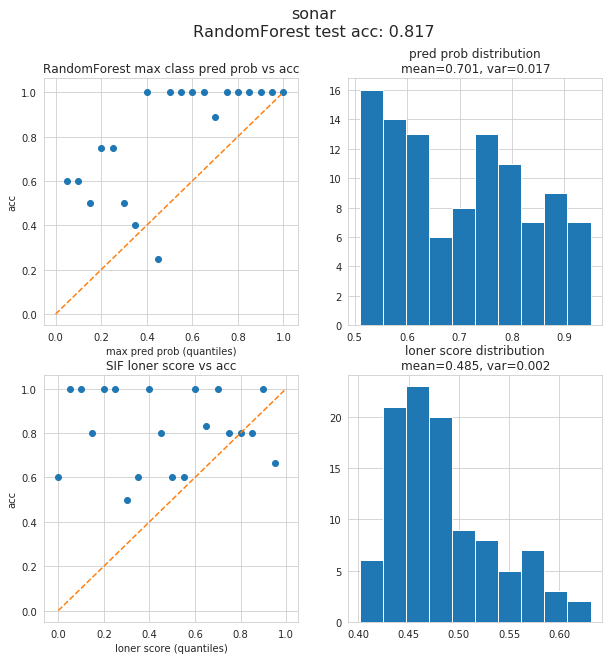

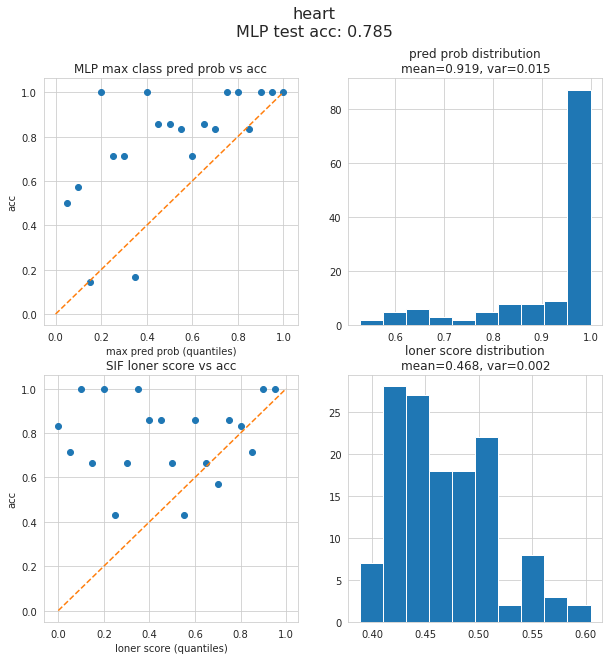

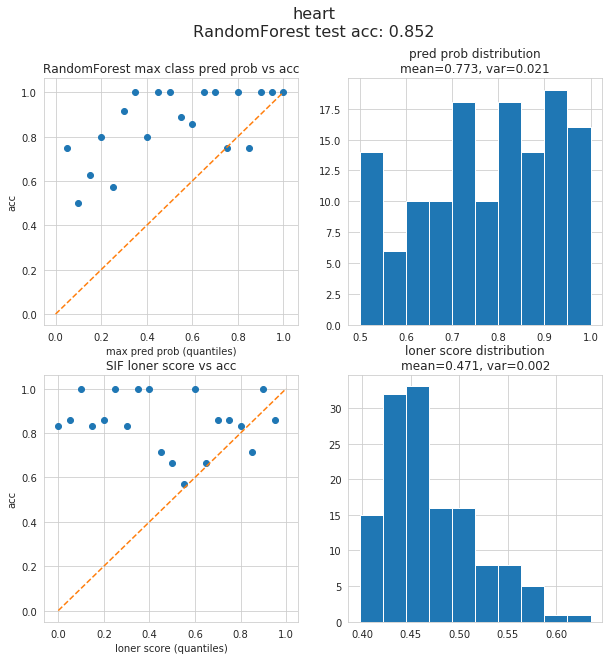

/home/aaysus/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


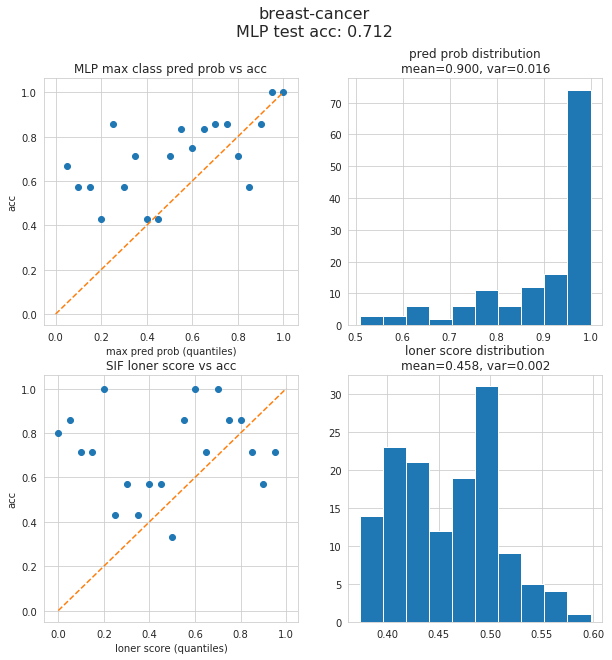

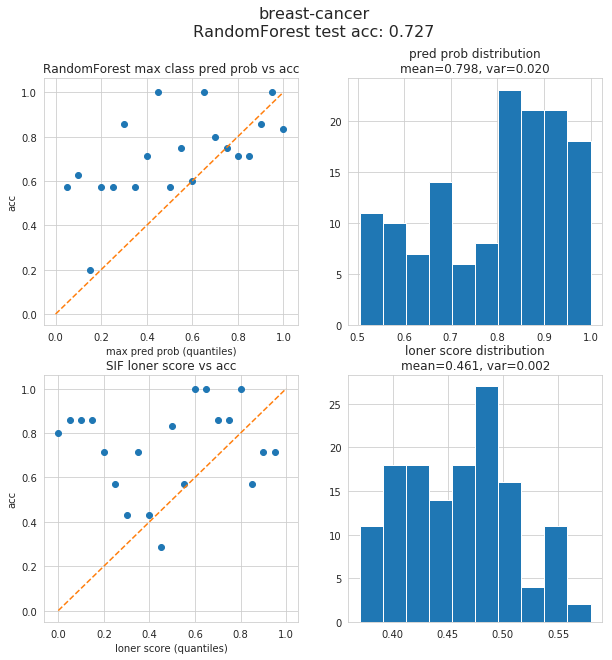

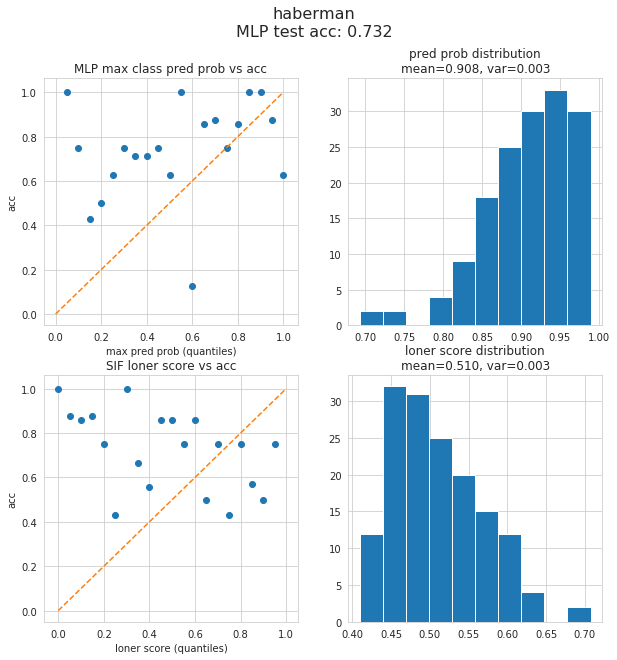

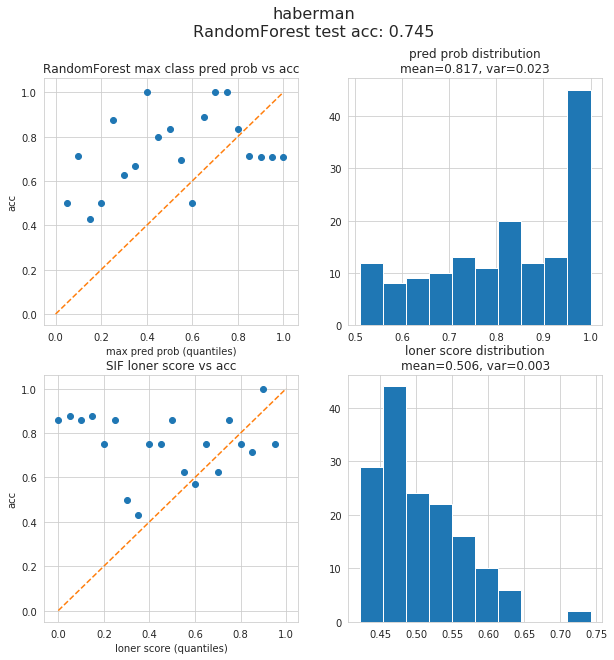

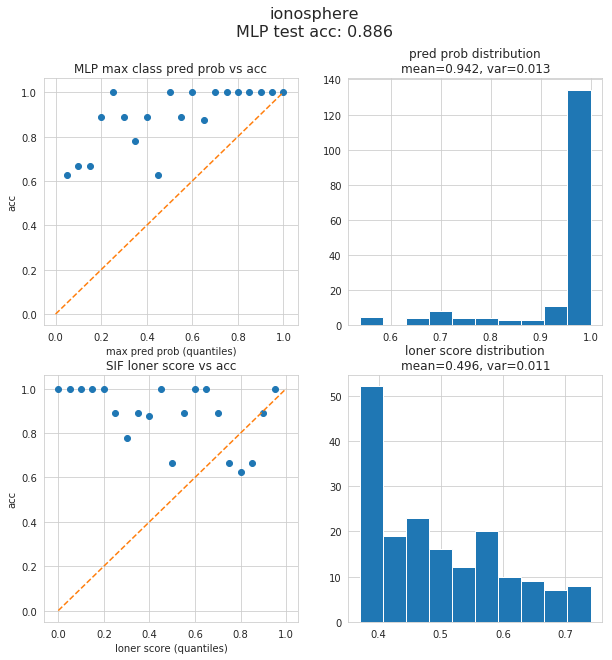

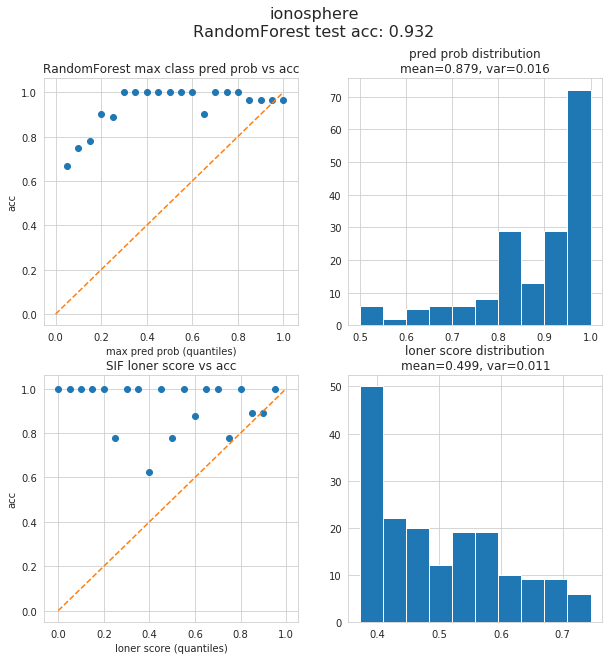

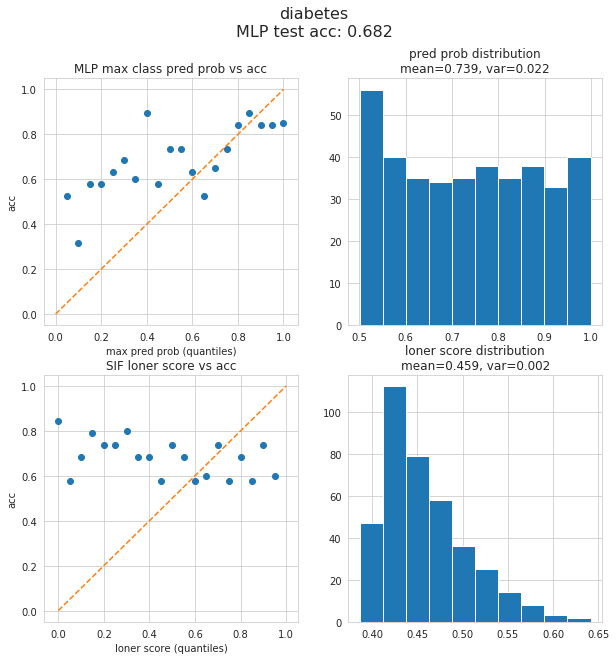

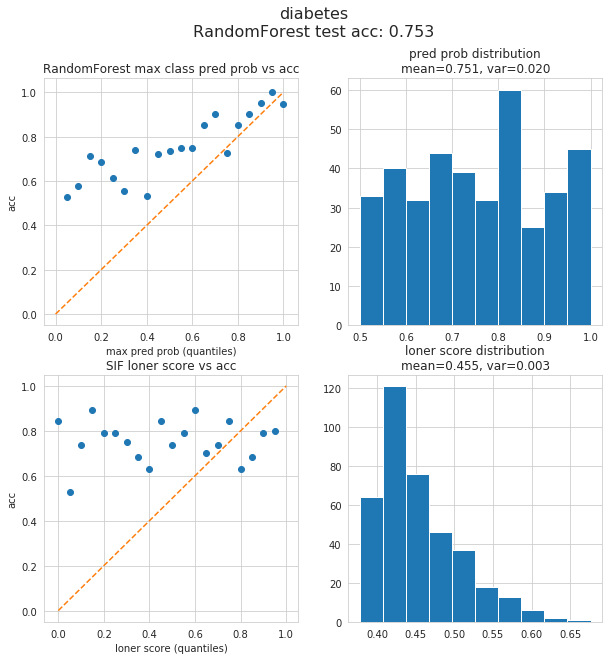

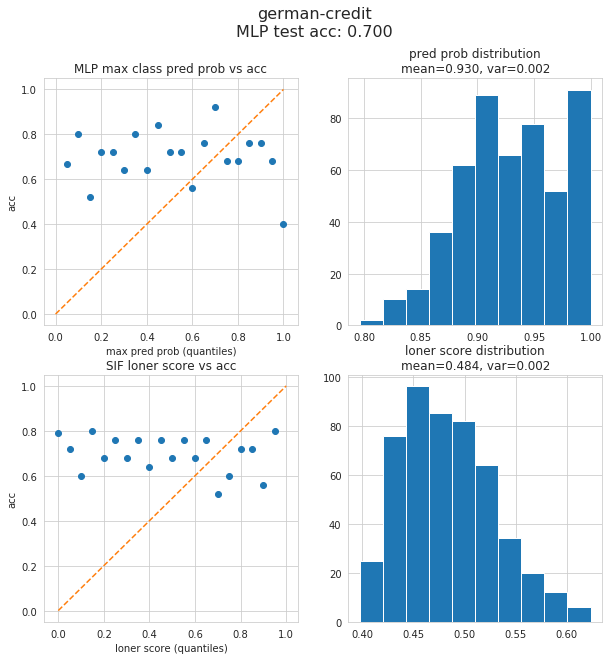

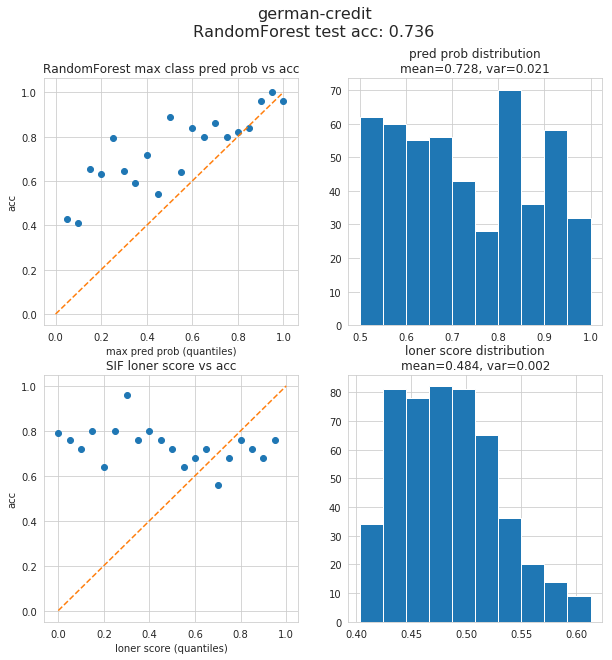

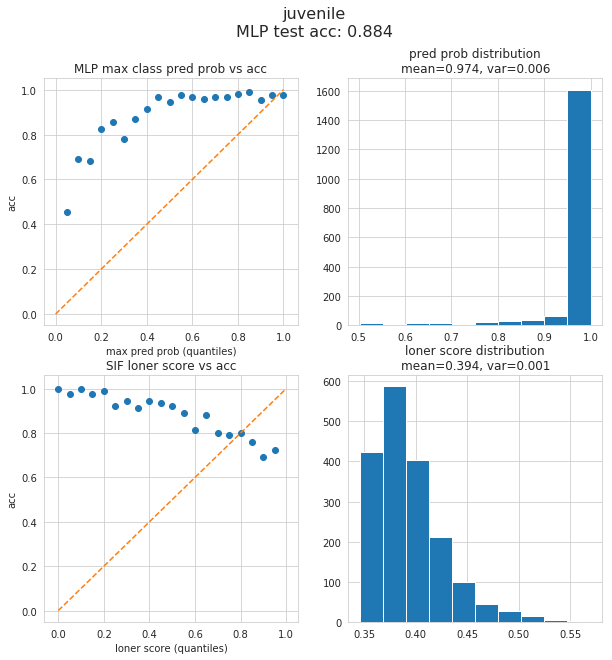

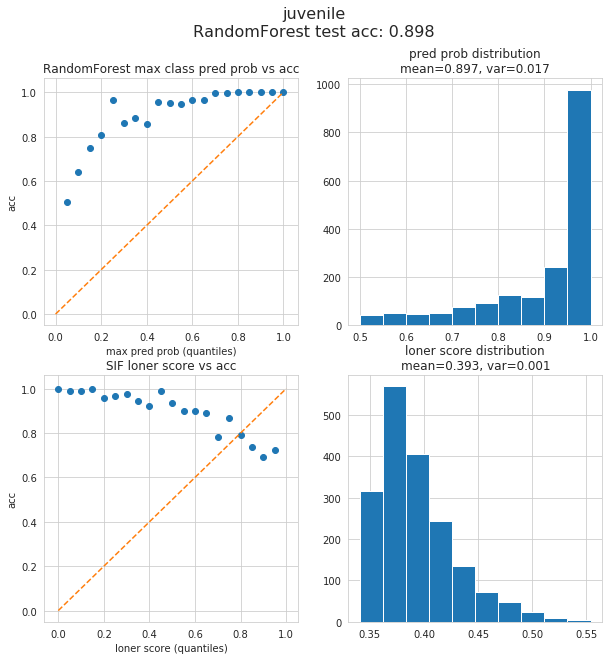

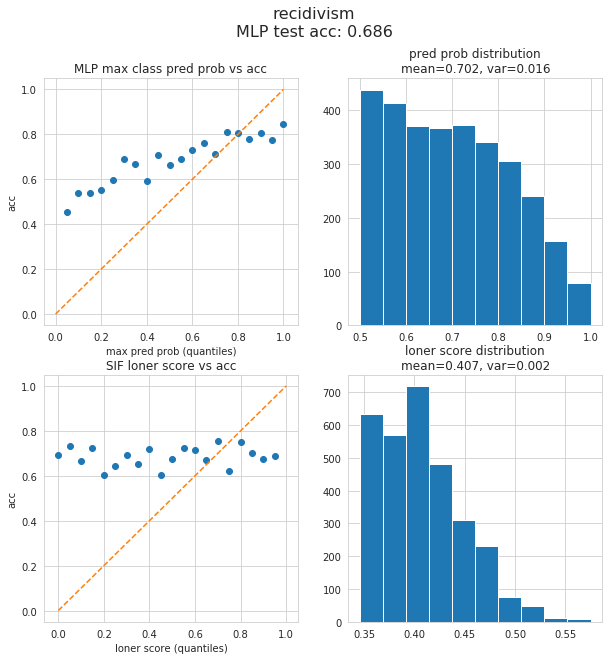

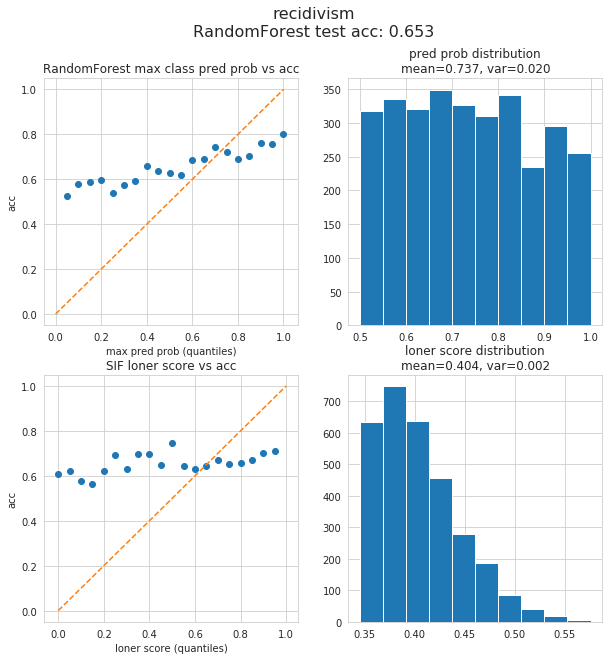

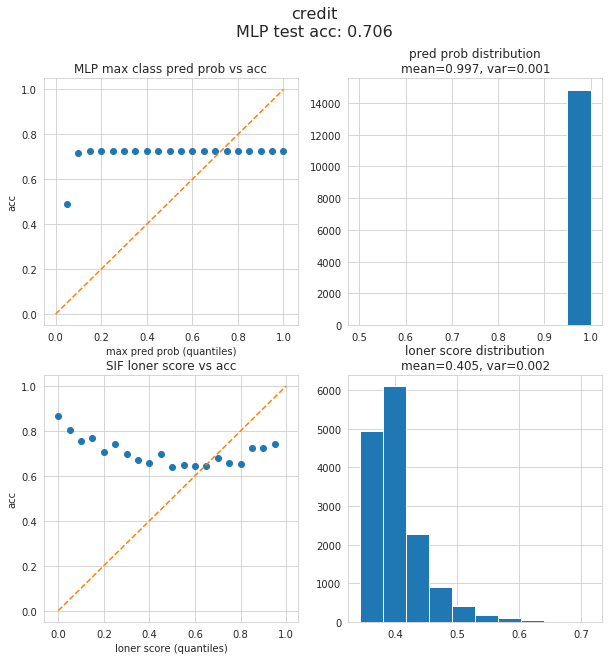

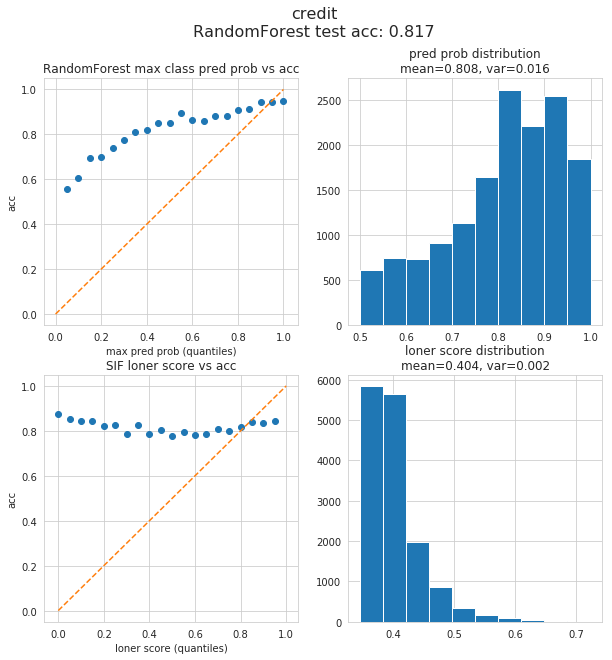

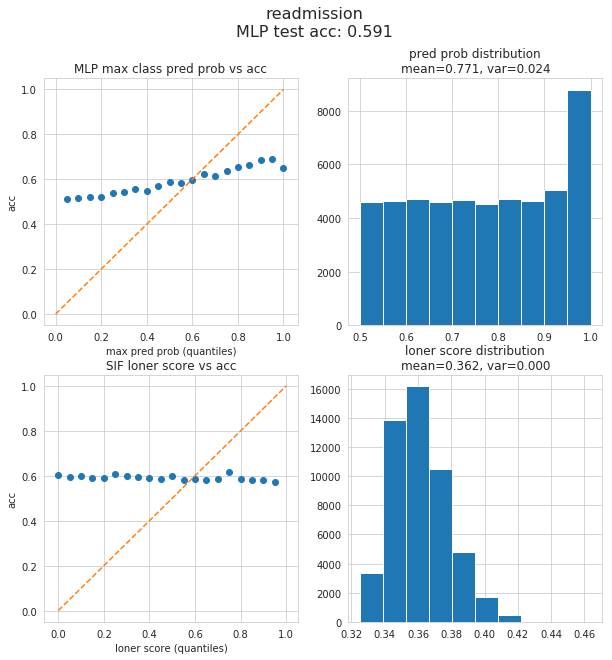

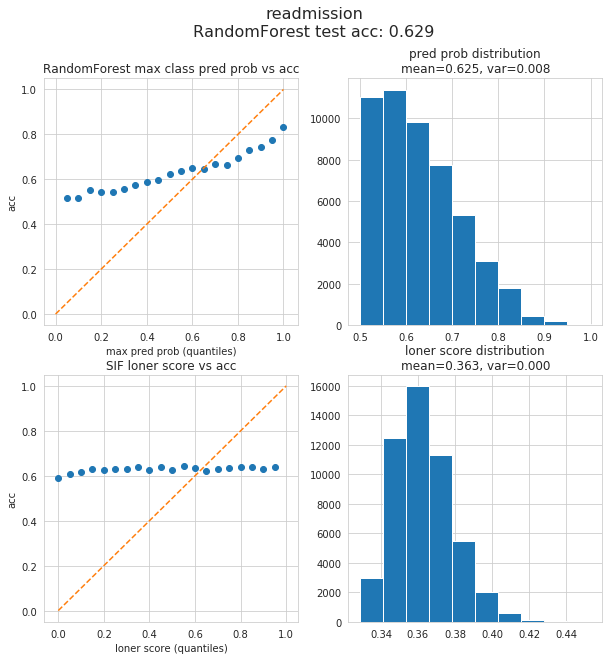

In [31]:
for name, ds in zip(names, datasets):
    for clf in classifiers:
        for el in [0, 1]:
            if name in to_test and clf in to_test and el in to_test:
                plot_sif_score_vs_acc(ds, name, n_trees=100, el=el, classifier=clf)